In [5]:
from bertopic import BERTopic
import re
import pandas as pd
from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import spacy



In [1]:
from bertopic import BERTopic
import re
import pandas as pd
from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import spacy

import pandas as pd #import pandas
df=pd.read_csv('transfered_csv_after_promo_4014.csv') 

In [49]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [50]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [51]:
# Remove Punctuations
df['full_txt_cleaned'] = df['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['full_txt_cleaned'] = df['full_txt_cleaned'].map(lambda x: x.lower())

In [52]:
data = df.full_txt_cleaned.values.tolist()
data_words = list(sent_to_words(data))

In [53]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [54]:
stop_words = stopwords.words('english')

In [55]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['make', 'sense', 'nrt', 'amp', 'vape', 'work', 'get', 'vln', 'last', 'book', 'script', 'vape', 'amp', 'flavour', 'approve', 'inhalation', 'weseal', 'get', 'wish', 'kick', 'tobacco', 'nuts', 'merky', 'cartel', 'lot', 'hollieahughe', 'mattjcan', 'ruthy']]


In [56]:
# Keeps only the tokens with more than 3 letters
tokens = [[word for word in words if len(word)>3] for words in data_lemmatized]
df['full_txt_cleaned'] = [" ".join(words) for words in tokens]
df['full_txt_cleaned'].head()

0    make sense vape work last book script vape fla...
1    wiki volunteer look study explore side issue d...
2    batshittery reduce nicotine cigarette nicotine...
3    potential scenario current communication nicot...
4    imaracingmom ncidirector exactly cigarette ple...
Name: full_txt_cleaned, dtype: object

In [57]:
data = df['full_txt_cleaned'].to_list()
timestamp = df['created_at'].to_list()

In [58]:
from collections import Counter
def format_topics_sentences(model, topics):
    # Init output
    sent_topics_df = pd.DataFrame()
    # ----- Finding the dominant topic in each sentence -----
    print(
        "\n******Finding the dominant topic in each sentence******\n")

    # Get main topic in each document
    for i, row in enumerate(data):
        cur_topic_index = topics[i]
        # cur_prob_dis = probs[i]
        # cur_prob = probs[i][np.argmax(cur_prob_dis)]
        cur_prob = 1
        cur_topic = model.get_topic(cur_topic_index)

        topic_keywords = ", ".join([word for word, prop in cur_topic])
        sent_topics_df = sent_topics_df.append(pd.Series(
                    [cur_topic_index, round(cur_prob, 4), topic_keywords, row]), ignore_index=True)

    sent_topics_df = sent_topics_df.reset_index()
    sent_topics_df.columns = [
            'Document_No',
            'Dominant_Topic',
            'Topic_Perc_Contrib',
            'Keywords',
            'Text']

    items = Counter(topics).keys()
    num_topic=len(items)
    

    sent_topics_df.to_csv(
        
        'sent_topics' +
        str(num_topic) +
        '.csv')

    #  ----- Find the most representative document for each topic -----
    print(
        "\n******Find the most representative document for each topic******\n")

    # Group top 20 sentences under each topic
    df_topic_sents_keywords = sent_topics_df
    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby(
        'Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(
            ['Topic_Perc_Contrib'], ascending=[0]).head(1)], axis=0)

    # Reset Index
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    #sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    sent_topics_sorteddf_mallet.to_csv(
        'sent_topics_sorted_' + str(num_topic) + '.csv')

    df = sent_topics_df
    df.Dominant_Topic = df.Dominant_Topic.astype(int)
    df["count"] = 1
    df = df.groupby("Dominant_Topic").sum().reset_index(
        "Dominant_Topic").drop(columns=["Document_No", "Topic_Perc_Contrib"])

    df_topic_info = sent_topics_sorteddf_mallet
    df = df.merge(df_topic_info, on="Dominant_Topic").drop(
        columns=["Document_No", "Topic_Perc_Contrib"])
    df.rename(columns={"Dominant_Topic": "dominant_topic_id",
                        "count": "num_tweets",
                        "Keywords": "topic_keywords",
                        "Text": "example_tweet"},
                inplace=True)

    df["perc_tweets"] = df.num_tweets / df.num_tweets.sum()
    df = df[["dominant_topic_id", "topic_keywords",
                "num_tweets", "perc_tweets", "example_tweet"]]
    df = df.sort_values("num_tweets", ascending=False)
    df.index = np.arange(len(df))
    df.to_csv( 'final_res_' + str(num_topic) + '.csv')

In [59]:
from gensim.models import CoherenceModel
import spacy
import gensim.corpora as corpora

In [60]:
stop_words = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com']
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=3, min_dist=0.2, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=400, min_samples=5, max_cluster_size=30000,
                        gen_min_span_tree=True,
                        prediction_data=True,
                        metric='euclidean')
cluster_model = KMeans(n_clusters=30)
vectorizer_model = CountVectorizer(max_df=0.9, min_df = 0.1, ngram_range=(1, 4), stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')
try:
    # Adds and deletes the nr_topic as needed. Most of the time, optimal values lies in [3,20]
#     nrs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30]
    nrs = [5, 6, 7, 8, 9, 10]
    scores_cv = {}
    for nr in nrs:
        print(f'Working on nr_topics = {nr}.')
        model = BERTopic(
            umap_model=umap_model,
            hdbscan_model=cluster_model,
            embedding_model=embedding_model,
            vectorizer_model=vectorizer_model,
            nr_topics=nr,
#             top_n_words=7,
            language='english',
            calculate_probabilities=True,
            verbose=True,
            diversity=0.8
        )
#         model = BERTopic(language='english', calculate_probabilities=False,verbose=True,nr_topics=nr)
        topics, probs = model.fit_transform(df['full_txt_cleaned'])
        topics_over_time = model.topics_over_time(data, timestamp)
        topics_over_time.to_csv('overtime'+ str(nr) + '.csv',index=False)
#         model.get_topic_info()
        fig1=model.visualize_hierarchy()
        fig1.write_html("hier_"+str(nr) +".html")
        fig2=model.visualize_topics_over_time(topics_over_time, top_n_topics=nr)
        fig2.write_html("overtimeplot"+str(nr) +".html")
        if __name__ == '__main__':
            format_topics_sentences(model, topics)
#         format_topics_sentences(model, topics)
        # Preprocess Documents
        documents = pd.DataFrame({"Document": df['full_txt_cleaned'].values,
                                  "ID": range(len(df['full_txt_cleaned'])),
                                  "Topic": topics})
        documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        cleaned_docs = model._preprocess_text(documents_per_topic.Document.values)

        # Extract vectorizer and analyzer from BERTopic
        vectorizer = model.vectorizer_model
        analyzer = vectorizer.build_analyzer()

        # Extract features for Topic Coherence evaluation
        words = vectorizer.get_feature_names()
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in model.get_topic(topic)] 
                       for topic in range(len(set(topics))-1)]
        # Evaluate
        coherence_model = CoherenceModel(topics=topic_words, 
                                         texts=tokens, 
                                         corpus=corpus,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence = coherence_model.get_coherence()
        scores_cv[nr] = coherence      
        print(f'Done.')
except KeyboardInterrupt as e:
    print(e)

Working on nr_topics = 5.


Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 03:36:03,628 - BERTopic - Transformed documents to Embeddings
2023-01-06 03:36:20,737 - BERTopic - Reduced dimensionality
2023-01-06 03:36:21,128 - BERTopic - Clustered reduced embeddings
2023-01-06 03:36:26,909 - BERTopic - Reduced number of topics from 30 to 5
3992it [16:51,  3.95it/s]



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 03:54:10,627 - BERTopic - Transformed documents to Embeddings
2023-01-06 03:54:27,228 - BERTopic - Reduced dimensionality
2023-01-06 03:54:27,609 - BERTopic - Clustered reduced embeddings
2023-01-06 03:54:33,251 - BERTopic - Reduced number of topics from 30 to 6
3992it [16:21,  4.07it/s]



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 04:11:47,116 - BERTopic - Transformed documents to Embeddings
2023-01-06 04:12:02,505 - BERTopic - Reduced dimensionality
2023-01-06 04:12:02,881 - BERTopic - Clustered reduced embeddings
2023-01-06 04:12:08,638 - BERTopic - Reduced number of topics from 30 to 7
3992it [16:27,  4.04it/s]



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 04:29:26,932 - BERTopic - Transformed documents to Embeddings
2023-01-06 04:29:41,951 - BERTopic - Reduced dimensionality
2023-01-06 04:29:42,316 - BERTopic - Clustered reduced embeddings
2023-01-06 04:29:48,081 - BERTopic - Reduced number of topics from 30 to 8
3992it [19:02,  3.49it/s]



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 04:49:43,322 - BERTopic - Transformed documents to Embeddings
2023-01-06 04:49:58,511 - BERTopic - Reduced dimensionality
2023-01-06 04:49:58,887 - BERTopic - Clustered reduced embeddings
2023-01-06 04:50:04,944 - BERTopic - Reduced number of topics from 30 to 9
3992it [22:33,  2.95it/s] 



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

2023-01-06 05:13:29,491 - BERTopic - Transformed documents to Embeddings
2023-01-06 05:13:44,767 - BERTopic - Reduced dimensionality
2023-01-06 05:13:45,113 - BERTopic - Clustered reduced embeddings
2023-01-06 05:13:51,239 - BERTopic - Reduced number of topics from 30 to 10
3992it [39:11,  1.70it/s] 



******Finding the dominant topic in each sentence******


******Find the most representative document for each topic******

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

<AxesSubplot:xlabel='nr'>

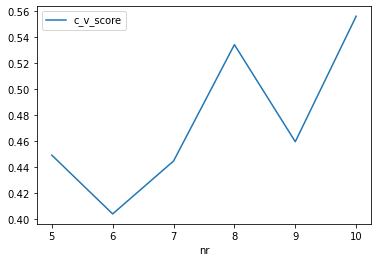

In [61]:
score_df = pd.DataFrame(scores_cv.items(), columns=['nr', 'c_v_score'])
score_df.plot(x='nr',y='c_v_score')

In [62]:
score_df

,nr,c_v_score
0,5,0.449300
1,6,0.404170
2,7,0.444752
3,8,0.534121
4,9,0.459600
5,10,0.555920
